In [246]:
import pandas as pd
from IPython.display import clear_output
import io
import os
import glob
import zipfile
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm

seed=77
np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

In [247]:
# Path to extract the contents of the zip file
extract_path = './DataSet/'
# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

In [248]:
chexpert_meta_data = pd.read_csv(extract_path+'train_visualCheXbert.csv')

In [249]:
chexpert_meta_data.head(2)

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [250]:
chexpert_meta_data.head(2)

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [251]:
chexpert_meta_data['path_splited'] = chexpert_meta_data['Path'].str.split('/')
chexpert_meta_data['patientid'] = chexpert_meta_data['path_splited'].apply(lambda x: x[2])

# Insert 'patient_id' column at the second position
chexpert_meta_data.insert(1, 'patient_id', chexpert_meta_data['patientid'])

# Drop the intermediate 'path_splited' column
chexpert_meta_data.drop('path_splited', axis=1, inplace=True)
chexpert_meta_data.drop('patientid', axis=1, inplace=True)

In [252]:
chexpert_meta_data.head(2)

,Path,patient_id,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,patient00001,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,patient00002,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [253]:
chexpert_demo= pd.read_excel(extract_path+'CHEXPERT DEMO.xlsx')

In [254]:
chexpert_demo.head(2)

,PATIENT,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY
0,patient24428,Male,61,White,Non-Hispanic/Non-Latino
1,patient48289,Female,39,Other,Hispanic/Latino


In [255]:
# merge chexpert_meta_data with chexpert_demo
merged_chexpert_df = pd.merge(chexpert_meta_data, chexpert_demo, left_on='patient_id', right_on='PATIENT', how='inner')

In [256]:
merged_chexpert_df.shape

(222561, 25)

In [257]:
# Define the desired order of columns
desired_columns_order = ['Path', 'patient_id', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'PATIENT','GENDER',
                         'PRIMARY_RACE','ETHNICITY','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
                         'Lung Lesion', 'Edema','Consolidation', 'Pneumonia','Atelectasis','Pneumothorax',
                         'Pleural Effusion', 'Pleural Other','Fracture', 'Support Devices','No Finding'
                         ]
# Reorder the columns in the merged DataFrame
reordered_CXP_df = merged_chexpert_df[desired_columns_order]

In [258]:
reordered_CXP_df['Age'] = reordered_CXP_df['Age'].astype('int64')

reordered_CXP_df.insert(reordered_CXP_df.columns.get_loc('Age') + 1, 'age_decile', None)

# Define custom bin edges and labels
bin_edges = [0, 20, 40, 60, 80, float('inf')]
bin_labels = ['0-20', '20-40', '40-60', '60-80', '80+']

# Use cut to create age deciles based on custom bins
reordered_CXP_df['age_decile'] = pd.cut(reordered_CXP_df['Age'],
                                    bins=bin_edges, labels=bin_labels,
                                    right=False)
display(reordered_CXP_df.head(2))

C:\Users\gebre\AppData\Local\Temp\ipykernel_10804\2661509669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reordered_CXP_df['Age'] = reordered_CXP_df['Age'].astype('int64')


,Path,patient_id,Sex,Age,age_decile,Frontal/Lateral,AP/PA,PATIENT,GENDER,PRIMARY_RACE,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,patient00001,Female,68,60-80,Frontal,AP,patient00001,Female,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,patient00002,Female,87,80+,Frontal,AP,patient00002,Female,"White, non-Hispanic",...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [259]:
reordered_CXP_df.PRIMARY_RACE.value_counts()

PRIMARY_RACE
White                                        102402
Other                                         28095
White, non-Hispanic                           22154
Asian                                         20434
Unknown                                       15186
Black or African American                      9909
Race and Ethnicity Unknown                     8716
Other, Hispanic                                3621
Native Hawaiian or Other Pacific Islander      2809
Asian, non-Hispanic                            2793
Black, non-Hispanic                            2000
White, Hispanic                                 922
Other, non-Hispanic                             566
American Indian or Alaska Native                457
Patient Refused                                 405
Pacific Islander, non-Hispanic                  337
Native American, non-Hispanic                    55
Black, Hispanic                                  52
Asian, Hispanic                                  37

In [260]:
race_mapping = {
    'White': 'White',
    'White, non-Hispanic': 'White',
    'White or Caucasian': 'White',
    'Black or African American': 'Black',
    'Black, non-Hispanic': 'Black',
    'Other':'Other',
    'Other, non-Hispanic':'Other',
    'Black, Hispanic':'Hispanic',
    'White, Hispanic':'Hispanic',
    'Other, Hispanic':'Hispanic',
    'Pacific Islander, Hispanic':'Hispanic',
    'Native American, Hispanic':'Hispanic',
    'Asian':'Asian',
    'Asian, Hispanic':'Asian',
    'Asian - Historical Conv':'Asian',
    'Asian, non-Hispanic':'Asian',
    'Native Hawaiian or Other Pacific Islander':'American Indian/Alaska native',
    'American Indian or Alaska Native':'American Indian/Alaska native',
    'Pacific Islander, non-Hispanic':'American Indian/Alaska native',
    'Native American, non-Hispanic':'American Indian/Alaska native'
}

In [261]:
# Apply the mapping to create a new column 'Race'
reordered_CXP_df['Race'] = reordered_CXP_df['PRIMARY_RACE'].map(race_mapping)

In [262]:
# Check the value counts of the race now
print(reordered_CXP_df['Race'].value_counts())

Race
White                            124569
Other                             28661
Asian                             23272
Black                             11909
Hispanic                           4630
American Indian/Alaska native      3658
Name: count, dtype: int64


In [263]:
reordered_CXP_df = reordered_CXP_df.drop(columns=['ETHNICITY','Age','Frontal/Lateral','AP/PA','PRIMARY_RACE'], axis=1)

In [264]:
reordered_CXP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222561 entries, 0 to 222560
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Path                        222561 non-null  object  
 1   patient_id                  222561 non-null  object  
 2   Sex                         222561 non-null  object  
 3   age_decile                  222561 non-null  category
 4   PATIENT                     222561 non-null  object  
 5   GENDER                      222561 non-null  object  
 6   Enlarged Cardiomediastinum  222561 non-null  float64 
 7   Cardiomegaly                222561 non-null  float64 
 8   Lung Opacity                222561 non-null  float64 
 9   Lung Lesion                 222561 non-null  float64 
 10  Edema                       222561 non-null  float64 
 11  Consolidation               222561 non-null  float64 
 12  Pneumonia                   222561 non-null  float64 
 13 

In [265]:
reordered_CXP_df.rename(columns={'Path':'path'},inplace=True)

In [266]:
reordered_CXP_df.shape

(222561, 21)

In [267]:
reordered_CXP_df = reordered_CXP_df[reordered_CXP_df.Race .isin(['White','Asian','Black'])]
reordered_CXP_df.shape

(159750, 21)

In [268]:
# Path to the extracted npz files
train_file_path = os.path.join(extract_path, 'train.npz')

validation_file_path = os.path.join(extract_path, 'validation.npz')

In [269]:
# Load the datasets
chexpert_dataset = np.load(train_file_path, allow_pickle=True)

cxp_validation_dataset = np.load(validation_file_path, allow_pickle=True)

In [270]:
print(f'Length of train dataset : {len(chexpert_dataset)}')
print(f'Length of validation dataset : {len(cxp_validation_dataset)}')

Length of train dataset : 223414
Length of validation dataset : 234


In [ ]:
for key in cxp_validation_dataset.keys():
  print(key,cxp_validation_dataset[key])
  break

In [ ]:
cxp_val_df=pd.DataFrame(list(cxp_validation_dataset.items()), columns=['path', 'features'])

In [ ]:
cxp_val_df.head(2)

In [ ]:
# Convert train_dataset to a Pandas DataFrame for efficient merging
train_df = pd.DataFrame(list(chexpert_dataset.items()), columns=['path', 'features'])

In [271]:
train_df.head(2)

,path,features
0,CheXpert-v1.0/train/patient00001/study1/view1_...,"[-0.6499777436256409, -2.122708320617676, 0.84..."
1,CheXpert-v1.0/train/patient00002/study1/view1_...,"[0.45629817247390747, -1.0862308740615845, 0.7..."


In [272]:
# Merge metadata with train_dataset
cxp_df = pd.merge(reordered_CXP_df, train_df, on='path', how='inner')

In [273]:
cxp_df.head(2)

,path,patient_id,Sex,age_decile,PATIENT,GENDER,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,Race,features
0,CheXpert-v1.0/train/patient00002/study2/view1_...,patient00002,Female,80+,patient00002,Female,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,White,"[0.17246507108211517, -1.5009434223175049, 0.5..."
1,CheXpert-v1.0/train/patient00002/study1/view1_...,patient00002,Female,80+,patient00002,Female,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,White,"[0.45629817247390747, -1.0862308740615845, 0.7..."


In [274]:
unique_pathId = cxp_df.patient_id.unique()

train_percent, valid_percent, test_percent = 0.80, 0.10, 0.10

unique_path_id = shuffle(unique_pathId)
value1 = (round(len(unique_path_id)*train_percent))
value2 = (round(len(unique_path_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_path_id)*test_percent))

In [ ]:
print("Patients in training set: " + str(value1))

In [ ]:
print("Patients in validation set: " + str(value2))

In [ ]:
print("Patients in testing set: " + str(value4))

In [275]:
data_df = shuffle(cxp_df)

train_path_id = unique_path_id[:value1]
validate_path_id = unique_path_id[value1:value3]
test_path_id = unique_path_id[value3:]

print(type(train_path_id))
print(train_path_id)

<class 'numpy.ndarray'>
['patient36322' 'patient46910' 'patient19809' ... 'patient14560'
 'patient39680' 'patient32882']


In [276]:
data_df.insert(7, "split","none", True)

In [ ]:
data_df.info()

In [ ]:
data_df.shape

In [277]:
data_df.loc[data_df.patient_id.isin(train_path_id), "split"]="train"
data_df.loc[data_df.patient_id.isin(validate_path_id), "split"]="validate"
data_df.loc[data_df.patient_id.isin(test_path_id), "split"]="test"

In [279]:
data_df.split.value_counts()

split
train       127665
test         16270
validate     15815
Name: count, dtype: int64

In [278]:
df_train = data_df[data_df["split"] == "train"]
df_validate = data_df[data_df["split"] == "validate"]

df_test = data_df[data_df["split"] == "test"]

In [280]:
df_train['features'][0]

array([ 0.17246507, -1.50094342,  0.51710474, ..., -0.61355996,
       -0.13626705, -0.52206457])

In [281]:
label_encoder = LabelEncoder()
df_train['Race'] = label_encoder.fit_transform(df_train['Race'])
df_validate['Race'] = label_encoder.fit_transform(df_validate['Race'])
df_test['Race'] = label_encoder.fit_transform(df_test['Race'])

C:\Users\gebre\AppData\Local\Temp\ipykernel_10804\1183629535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Race'] = label_encoder.fit_transform(df_train['Race'])
C:\Users\gebre\AppData\Local\Temp\ipykernel_10804\1183629535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validate['Race'] = label_encoder.fit_transform(df_validate['Race'])
C:\Users\gebre\AppData\Local\Temp\ipykernel_10804\1183629535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [282]:
y_train_encoded = label_encoder.fit_transform(df_train.Race)
y_val_encoded = label_encoder.transform(df_validate.Race)
y_test_encoded = label_encoder.transform(df_test.Race)

In [283]:
# Convert integer labels to one-hot encoding
class_names = data_df['Race'].unique()
num_classes=len(class_names)

y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

In [284]:
y_train_one_hot[0]

array([0., 0., 1.], dtype=float32)

In [285]:
# Create tf.data.Dataset objects for the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.features.values.tolist(), y_train_one_hot))
for train in train_dataset.take(2):
  print(train)

(<tf.Tensor: shape=(1376,), dtype=float64, numpy=
array([-0.0405456 , -1.14362776,  0.33787656, ..., -0.66189224,
        0.44230166, -1.22709286])>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)
(<tf.Tensor: shape=(1376,), dtype=float64, numpy=
array([-0.61324561, -1.05047369,  0.7036972 , ..., -0.94813776,
        0.92725366,  0.02144859])>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


In [286]:
validation_dataset = tf.data.Dataset.from_tensor_slices((df_validate.features.values.tolist(),y_val_one_hot))


In [287]:
test_dataset = tf.data.Dataset.from_tensor_slices((df_test.features.values.tolist(),y_test_one_hot))


# Create and Train Model

In [288]:
embeddings_size=1376
learning_rate=0.000147
batch_size = 256
epochs = 50
end_lr_factor=1.0
dropout_rate=0.2
decay_steps=1000
loss_weights=None
weight_decay = 0.001
hidden_layer_sizes = [256, 128, 64]

In [289]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [290]:
# Define a function to build the model
def build_model(
    # hp
    ):

  # Hyperparameters
  # learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
  # batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128,256])
  # dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
  # weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='log')
  # hidden_layer_sizes = [hp.Int(f'hidden_{i}', min_value=64, max_value=512, step=64) for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=4))]


  inputs = Input(shape=(embeddings_size,))
  # Build the model using the Functional API
  hidden = inputs
  for size in hidden_layer_sizes:
    hidden = Dense(size,
                   activation='relu',
                   kernel_initializer=HeUniform(),
                   kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
                   bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(dropout_rate)(hidden)

  output = Dense(num_classes, activation='softmax', kernel_initializer=HeUniform())(hidden)
  # Create the model
  model = Model(inputs=inputs, outputs=output)

  # Compile the model with accuracy and AUC as metrics
  model.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss='categorical_crossentropy',
      metrics=[AUC()])

  return model




In [ ]:
# Create the tuner
# tuner = RandomSearch(build_model,
#                      objective=Objective('val_auc', direction='max'),
#                      max_trials=10,  # Number of trials to run
#                      executions_per_trial=1,  # Number of executions per trial (use more for better robustness)
#                      directory='tuner_directory',
#                      project_name='my_tuning_project')

In [ ]:
# # Start the hyperparameter search
# tuner.search(x=train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
#              batch_size=batch_size,
#              epochs=20,
#              validation_data=validation_dataset.batch(batch_size).cache(),
#              callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

In [ ]:
# # Get the best hyperparameters
# best_hyperparameters = tuner.get_best_hyperparameters()[0]
# print("Best Hyperparameters:")
# print(best_hyperparameters.values)

In [ ]:
# # Build and compile the model using the best hyperparameters
# best_model = tuner.hypermodel.build(best_hyperparameters)
# best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters.get('learning_rate')),
#                    loss='binary_crossentropy',
#                    metrics=[AUC(multi_label=True)])

In [291]:
model = build_model()

In [292]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [293]:
# train the model
history=model.fit(
    x=train_dataset.batch(batch_size=256).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_dataset.batch(batch_size=256).cache(),
    callbacks=[early_stopping],
    epochs=epochs,
)

# {'learning_rate': 0.00014738588591369008, 'batch_size': 128, 'dropout_rate': 0.2,
#  'weight_decay': 0.00010163317846344261, 'num_hidden_layers': 4, 'hidden_0': 320, 'hidden_1': 448, 'hidden_2': 64,
#  'hidden_3': 64}

Epoch 1/50
499/499 [==============================] - 6s 10ms/step - loss: 1.9689 - auc_4: 0.6697 - val_loss: 1.4875 - val_auc_4: 0.8882
Epoch 2/50
499/499 [==============================] - 5s 10ms/step - loss: 1.5133 - auc_4: 0.8437 - val_loss: 1.2903 - val_auc_4: 0.9189
Epoch 3/50
499/499 [==============================] - 5s 11ms/step - loss: 1.3022 - auc_4: 0.8934 - val_loss: 1.1465 - val_auc_4: 0.9288
Epoch 4/50
499/499 [==============================] - 5s 10ms/step - loss: 1.1698 - auc_4: 0.9120 - val_loss: 1.0549 - val_auc_4: 0.9345
Epoch 5/50
499/499 [==============================] - 5s 11ms/step - loss: 1.0713 - auc_4: 0.9208 - val_loss: 0.9911 - val_auc_4: 0.9337
Epoch 6/50
499/499 [==============================] - 7s 15ms/step - loss: 0.9818 - auc_4: 0.9280 - val_loss: 0.9209 - val_auc_4: 0.9366
Epoch 7/50
499/499 [==============================] - 7s 13ms/step - loss: 0.9077 - auc_4: 0.9322 - val_loss: 0.8539 - val_auc_4: 0.9390
Epoch 8/50
499/499 [=====================

## Evaluate model performance over test set

In [294]:
def plot_evaluation_metrics(history):
    #Accuracy
    auc = history.history["auc"]
    val_auc = history.history["val_auc"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(auc) + 1)
    plt.plot(epochs, auc, "r", label="Training auc")
    plt.plot(epochs, val_auc, "g", label="Validation auc")

    plt.title("Training and validation auc")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [ ]:
plot_evaluation_metrics(history)

In [295]:
# Evaluate using ROC-AUC
y_pred_prob = model.predict(test_dataset.batch(batch_size=256))

y_pred_prob[0]

64/64 [==============================] - 1s 5ms/step


array([0.00625145, 0.00453651, 0.98921204], dtype=float32)

In [296]:
y_pred_prob[0]

array([0.00625145, 0.00453651, 0.98921204], dtype=float32)

In [297]:
# Calculate ROC-AUC for each class
n_classes = y_pred_prob.shape[1]  # Number of classes
n_classes

3

In [298]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [299]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
for class_idx in range(n_classes):
    # Extract true labels and predicted probabilities for the current class
    y_true = y_test_one_hot[:, class_idx]
    y_prob = y_pred_prob[:, class_idx]

    # Calculate ROC-AUC for the current class
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_true, y_prob)
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])


In [300]:
roc_auc

{0: 0.8799190099092729, 1: 0.8812279217731716, 2: 0.8719012649469042}

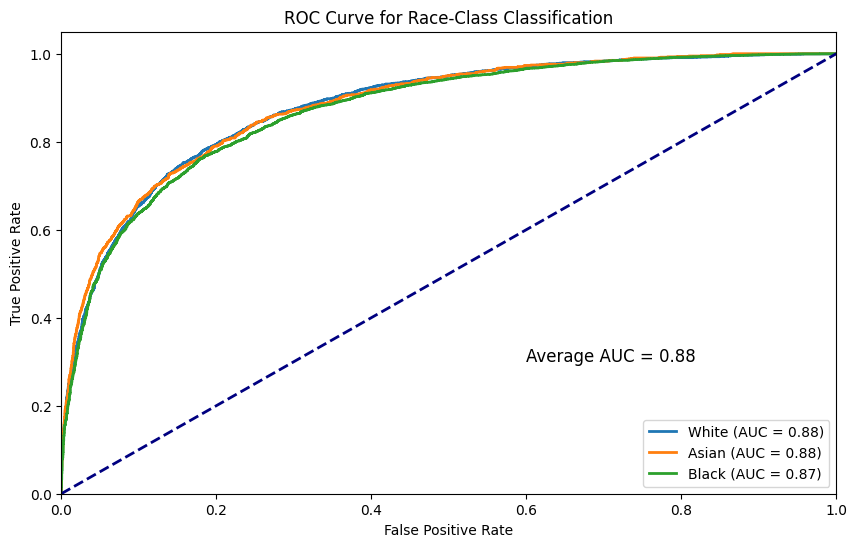

In [301]:
# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for class_idx in range(n_classes):
  plt.plot(fpr[class_idx], tpr[class_idx], lw=2, label=f'{class_names[class_idx]} (AUC = {roc_auc[class_idx]:.2f})')

# Calculate and display the average AUC score
average_auc = np.mean(list(roc_auc.values()))
plt.text(0.6, 0.3, f'Average AUC = {average_auc:.2f}', fontsize=12)

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Race-Class Classification')
plt.legend(loc='lower right')
plt.show()